In [1]:
# Importing Libraries
import pandas as pd 
import numpy as np 
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Loading dataset
data = pd.read_csv("test.tsv", sep='\t')
print(data.head())

   Unnamed: 0                                              title  \
0        8104  Conservatives Will HATE What Donald Trump Just...   
1        7467  Trump victory may create new tension between U...   
2        9473  WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...   
3         276  Democratic Senator Franken to resign: CNN, cit...   
4       19274  GANG OF DOMESTIC TERRORISTS Violently Attack L...   

                                                text       subject  \
0  Donald Trump isn t exactly a stranger to makin...          News   
1  Donald Trump’s U.S. election victory may creat...  politicsNews   
2  A couple of quick questions come to mind when ...      politics   
3  U.S. Democratic Senator Al Franken will announ...  politicsNews   
4  ***WARNING*** Violence is graphic***This Trump...     left-news   

                date  label  
0  February 14, 2016      0  
1  November 9, 2016       1  
2        Nov 9, 2017      0  
3  December 7, 2017       1  
4       Jan 21, 2017

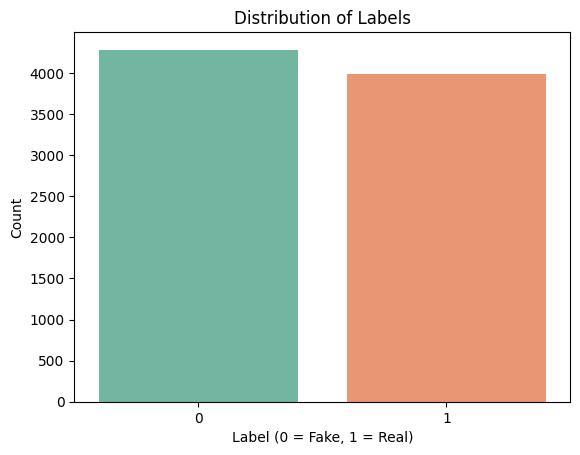

In [3]:
test_data = pd.read_csv('test.tsv', sep='\t')
sns.countplot(data=test_data, x='label', hue='label', palette='Set2', legend=False)
plt.title('Distribution of Labels')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.show()

In [4]:
# Checking for missing values
print(data.isnull().sum())
data = data.dropna()

Unnamed: 0    0
title         0
text          0
subject       0
date          0
label         0
dtype: int64


In [5]:
# Remove the unnecessary 'Unnamed: 0' column
data = data.drop(columns=['Unnamed: 0'])

In [6]:
# Removing duplicate rows
data = data.drop_duplicates()

In [7]:
# Initializing neccessary NLP tools
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zanwa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zanwa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [9]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Use spaCy's tokenizer
    doc = nlp(text)
    # Remove stopwords
    tokens = [token.text for token in doc if token.text not in stop_words]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [10]:
# applying the cleaning function to title and text columns
data['cleaned_title'] = data['title'].apply(clean_text)

In [ ]:
data['cleaned_text'] = data['text'].apply(clean_text)

In [13]:
print(data[['title', 'cleaned_title', 'text', 'cleaned_text']].head())

                                               title  \
0  Conservatives Will HATE What Donald Trump Just...   
1  Trump victory may create new tension between U...   
2  WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...   
3  Democratic Senator Franken to resign: CNN, cit...   
4  GANG OF DOMESTIC TERRORISTS Violently Attack L...   

                                       cleaned_title  \
0  conservative hate donald trump said planned pa...   
1  trump victory may create new tension u islam i...   
2  watch hundred illegal alien storm senate build...   
3  democratic senator franken resign cnn citing s...   
4  gang domestic terrorist violently attack lone ...   

                                                text  \
0  Donald Trump isn t exactly a stranger to makin...   
1  Donald Trump’s U.S. election victory may creat...   
2  A couple of quick questions come to mind when ...   
3  U.S. Democratic Senator Al Franken will announ...   
4  ***WARNING*** Violence is graphic***This Tr

In [14]:
data['title_length'] = data['cleaned_title'].apply(lambda x: len(x.split()))

In [15]:
data['text_length'] = data['cleaned_text'].apply(lambda x: len(x.split()))

In [16]:
from textblob import TextBlob
data['title_sentiment'] = data['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['text_sentiment'] = data['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [17]:
from sklearn.model_selection import train_test_split

X = data[['cleaned_title', 'cleaned_text', 'title_length', 'text_length']]
y = data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_text'])
X_val_tfidf = vectorizer.transform(X_val['cleaned_text'])

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=42)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_val_tfidf)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       850
           1       0.95      0.96      0.96       802

    accuracy                           0.96      1652
   macro avg       0.96      0.96      0.96      1652
weighted avg       0.96      0.96      0.96      1652



In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

y_pred = model.predict(X_val_tfidf)
y_pred_proba = model.predict_proba(X_val_tfidf)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

print("\nClassification Report:\n", classification_report(y_val, y_pred))


Evaluation Metrics:
Accuracy: 0.96
Precision: 0.95
Recall: 0.96
F1 Score: 0.96
AUC-ROC: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       850
           1       0.95      0.96      0.96       802

    accuracy                           0.96      1652
   macro avg       0.96      0.96      0.96      1652
weighted avg       0.96      0.96      0.96      1652



In [21]:
# Loading training dataset
train_data = pd.read_csv('train.tsv', sep='\t')
print(train_data.head())

   Unnamed: 0                                              title  \
0        2619  Ex-CIA head says Trump remarks on Russia inter...   
1       16043  YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...   
2         876  Federal Reserve governor Powell's policy views...   
3       19963  SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...   
4       10783  NANCY PELOSI ARROGANTLY DISMISSES Questions on...   

                                                text          subject  \
0  Former CIA director John Brennan on Friday cri...     politicsNews   
1  How did this man come to OWN this store? There...  Government News   
2  President Donald Trump on Thursday tapped Fede...     politicsNews   
3  Hillary Clinton ally David Brock is offering t...        left-news   
4  Pleading ignorance is a perfect ploy for Nancy...         politics   

                date  label  
0     July 22, 2017       1  
1       Jun 19, 2017      0  
2  November 2, 2017       1  
3       Sep 17, 2016      0  
4 

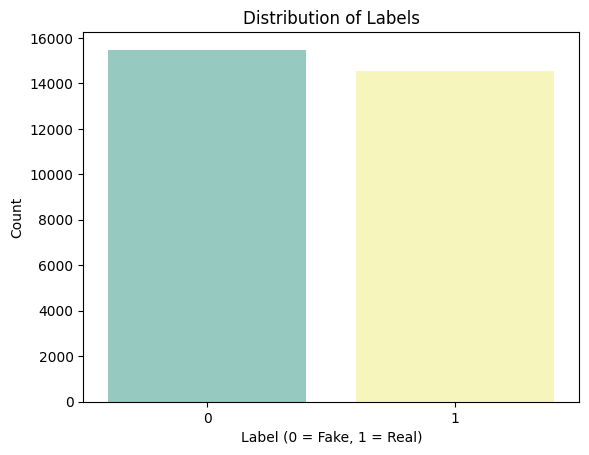

In [43]:
# Visualising train_data for the fake and real inputs
sns.countplot(data=train_data, x='label', hue='label', palette='Set3', legend=False)
plt.title('Distribution of Labels')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.show()

In [ ]:
print(train_data.isnull().sum())
train_data = train_data.dropna()

Unnamed: 0    0
title         0
text          0
subject       0
date          0
label         0
dtype: int64


In [24]:
train_data = train_data.drop(columns=['Unnamed: 0'])

In [25]:
tain_data = train_data.drop_duplicates()

In [26]:
train_data['cleaned_title'] = train_data['title'].apply(clean_text)

In [28]:
train_data['cleaned_text'] = train_data['text'].apply(clean_text)

In [29]:
print(train_data[['title', 'cleaned_title', 'text', 'cleaned_text']].head())

                                               title  \
0  Ex-CIA head says Trump remarks on Russia inter...   
1  YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...   
2  Federal Reserve governor Powell's policy views...   
3  SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...   
4  NANCY PELOSI ARROGANTLY DISMISSES Questions on...   

                                       cleaned_title  \
0  excia head say trump remark russia interferenc...   
1  wo nt believe punishment hispanic store owner ...   
2   federal reserve governor powell policy view word   
3  scoundrel hillary supporter start trumpleaks c...   
4  nancy pelosi arrogantly dismisses question cro...   

                                                text  \
0  Former CIA director John Brennan on Friday cri...   
1  How did this man come to OWN this store? There...   
2  President Donald Trump on Thursday tapped Fede...   
3  Hillary Clinton ally David Brock is offering t...   
4  Pleading ignorance is a perfect ploy for Na

In [30]:
train_data['title_length'] = train_data['cleaned_title'].apply(lambda x: len(x.split()))

In [31]:
train_data['text_length'] = train_data['cleaned_text'].apply(lambda x: len(x.split()))

In [32]:
from textblob import TextBlob
train_data['title_sentiment'] = train_data['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_data['text_sentiment'] = train_data['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [33]:
from sklearn.model_selection import train_test_split

X = train_data[['cleaned_title', 'cleaned_text', 'title_length', 'text_length']]
y = train_data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_text'])
X_val_tfidf = vectorizer.transform(X_val['cleaned_text'])

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

train_model = RandomForestClassifier(random_state=42)
train_model.fit(X_train_tfidf, y_train)

y_pred = train_model.predict(X_val_tfidf)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3137
           1       0.97      0.98      0.98      2863

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

y_pred = train_model.predict(X_val_tfidf)
y_pred_proba = train_model.predict_proba(X_val_tfidf)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

print("\nClassification Report:\n", classification_report(y_val, y_pred))

Evaluation Metrics:
Accuracy: 0.98
Precision: 0.97
Recall: 0.98
F1 Score: 0.98
AUC-ROC: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3137
           1       0.97      0.98      0.98      2863

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



In [38]:
print(train_data.head())

                                               title  \
0  Ex-CIA head says Trump remarks on Russia inter...   
1  YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...   
2  Federal Reserve governor Powell's policy views...   
3  SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...   
4  NANCY PELOSI ARROGANTLY DISMISSES Questions on...   

                                                text          subject  \
0  Former CIA director John Brennan on Friday cri...     politicsNews   
1  How did this man come to OWN this store? There...  Government News   
2  President Donald Trump on Thursday tapped Fede...     politicsNews   
3  Hillary Clinton ally David Brock is offering t...        left-news   
4  Pleading ignorance is a perfect ploy for Nancy...         politics   

                date  label  \
0     July 22, 2017       1   
1       Jun 19, 2017      0   
2  November 2, 2017       1   
3       Sep 17, 2016      0   
4       May 26, 2017      0   

                                     

In [39]:
import joblib

joblib.dump(train_model, 'news_classification_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("Model and vectorizer saved!")

Model and vectorizer saved!
